In [1]:
%run /home/analysis_user/New_trap_code/Tools/basic_packages.py


In [2]:
plt.rcParams["figure.figsize"] = (16,12)
plt.rcParams["font.size"] = 24
plt.rcParams['xtick.labelsize'] = "small"
plt.rcParams['ytick.labelsize'] = 36

In [3]:
def load_dir_reduced(dirname,file_prefix,max_files):
    '''
    Load time information from the h5 files in a loop into a list. Step size is fixed to 100. 
    '''   
    ## Load all filenames in directory
    var_list1 = []
    var_list2 = []
    files = []
    [files.append(file_) for file_ in os.listdir(dirname) if file_.startswith(file_prefix) if file_.endswith('.h5')]
    files.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    print(len(files))
    step_size = 50
    for j in tqdm(np.arange(0,max_files,step_size)):
        for filename in files[j:j+step_size]:
            BDFs = BDF.BeadDataFile(dirname+filename)
            var_list1.append(BDFs.x2)
            var_list2.append(BDFs.cant_pos[1])
    return var_list1,var_list2

In [ ]:
def data_to_amp_and_phase_single_axis(data,fsamp,res):
    data_det=signal.detrend(data)
    freqs=np.linspace(0,int(fsamp/2),(int(res/2))+1)    # change
    FFT=np.fft.rfft(data_det)
    norm = np.sqrt(2 / (res* fsamp))
    PSD = norm**2 * (FFT * FFT.conj()).real
    Phase =np.angle(FFT)
    return freqs,PSD,Phase

## verification of the methods comparability to previously used mlab.psd

# fsamp=5000
# res=50000
# data=f[0].x2
# a = data_to_amp_and_phase_single_axis(data,fsamp,res)
# b = matplotlib.mlab.psd(signal.detrend(data), Fs = fsamp, NFFT = res, window = mlab.window_none)
# plt.loglog(a[0],a[1])
# plt.loglog(b[1],b[0],alpha=0.5)

In [ ]:
def extract_data_to_df(folderName,filePrefix,maxFiles=1000,filterStd=True):
    ampList = []
    phaseList=[]
    
    df= pd.DataFrame()
    freqs=0
    fsamp=5000
    res=50000
    x2L,cPL = load_dir_reduced(folderName,file_prefix=filePrefix,max_files=maxFiles)
    for i in range(len(x2L)):
        #print(np.std(file.x2))
        data=x2L[i]
        temp_ = data_to_amp_and_phase_single_axis(data,fsamp,res)
        freqs=temp_[0]
        ampList.append(temp_[1])
        phaseList.append(temp_[2])
    df["cantPosY"] = cPL
    df["xAmp"] = x2L
    df["xPhase"] = phaseList
    df["xPSD"] = ampList
    df["checkStd"]=df["xAmp"].apply(lambda element: np.std(element))
    if(filterStd==True):
        df=df[df["checkStd"]<20*df["checkStd"].median()]
    return freqs,df

In [ ]:
def plotQuick(fundamental,df_1,df_2,label1,label2,offset,scaleFactor,lowylim=1e-10,upylim=1e-4,lowxlim=10,upxlim=140):
    xlabel="frequency [Hz]"
    ylabel="x sumPSD [a.u.]"
    plt.plot(freqs,df_1["xPSD"].sum(),color="black",alpha=1,lw=3,label=label1)
    plt.plot(freqs,df_2["xPSD"].sum()/scaleFactor,color="red",alpha=0.5,lw=3,label=label2)
    plt.yscale("log")
    plt.xlim(lowxlim,upxlim)
    plt.ylim(lowylim,upylim)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.legend()
    plt.show()
    
    plt.plot(freqs[fundamental*10::fundamental*10],df_1["xPSD"].sum()[fundamental*10::fundamental*10],color="black",alpha=1,lw=3,marker="*",ms=15,label=label1)
    plt.plot(freqs[fundamental*10::fundamental*10],(df_2["xPSD"].sum()/scaleFactor)[fundamental*10::fundamental*10],color="red",alpha=0.5,lw=3,marker="*",ms=15,label=label2)
    
    plt.plot(freqs[(fundamental+offset)*10::(fundamental+offset)*10],df_1["xPSD"].sum()[(fundamental+offset)*10::(fundamental+offset)*10],color="blue",alpha=0.5,lw=3,ls="dashed",marker="*",ms=15,label=label1+" off-axis check at %d" %(fundamental+offset))
    plt.plot(freqs[(fundamental+offset)*10::(fundamental+offset)*10],(df_2["xPSD"].sum()/scaleFactor)[(fundamental+offset)*10::(fundamental+offset)*10],color="blue",alpha=0.5,lw=3,ls="dotted",marker="*",ms=15,label=label2+" off-axis check at %d"%(fundamental+offset))

    plt.yscale("log")
    plt.xlim(fundamental/5,fundamental*12+fundamental/2)
    plt.ylim(lowylim,upylim)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

In [ ]:
def plotQuickAlternatemethod(fundamental,df_1,df_2,label1,label2,offset,scaleFactor,lowylim=1e-10,upylim=1e-4):
    
    data1=data_to_amp_and_phase_single_axis(df_1["xAmp"].sum(),5000,50000)[1]
    data2=data_to_amp_and_phase_single_axis(df_2["xAmp"].sum(),5000,50000)[1]            
    xlabel="frequency [Hz]"
    ylabel="x sumPSD [a.u.]"
    plt.plot(freqs,data1,color="black",alpha=1,lw=3,label=label1)
    plt.plot(freqs,data2/scaleFactor,color="red",alpha=0.5,lw=3,label=label2)
    plt.yscale("log")
    plt.xlim(fundamental/5,fundamental*12+fundamental/2)
    plt.ylim(lowylim,upylim)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.legend()
    plt.show()

    plt.plot(freqs[fundamental*10::fundamental*10],data1[fundamental*10::fundamental*10],color="black",alpha=1,lw=3,marker="*",ms=15,label=label1)
    plt.plot(freqs[fundamental*10::fundamental*10],data2[fundamental*10::fundamental*10]/scaleFactor,color="red",alpha=0.5,lw=3,marker="*",ms=15,label=label2)

    plt.plot(freqs[(fundamental+offset)*10::(fundamental+offset)*10],data1[(fundamental+offset)*10::(fundamental+offset)*10],color="blue",alpha=0.5,lw=3,ls="dashed",marker="*",ms=15,label=label1+" off-axis check at %d" %(fundamental+offset))
    plt.plot(freqs[(fundamental+offset)*10::(fundamental+offset)*10],data2[(fundamental+offset)*10::(fundamental+offset)*10]/scaleFactor,color="blue",alpha=0.5,lw=3,ls="dotted",marker="*",ms=15,label=label2+" off-axis check at %d"%(fundamental+offset))

    plt.yscale("log")
    plt.xlim(fundamental/5,fundamental*12+fundamental/2)
    plt.ylim(lowylim,upylim)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()                       

# 2022/05/02

In [60]:
folderName="/data/new_trap/20220502/Bead0/VibrationTest/NoShaking/"
filePrefix="NoShaking"
#files = load_dir_sorted(folderName,file_prefix=filePrefix,start_file=0,max_file=1000)
freqs,df_NoShaking = extract_data_to_df(folderName,filePrefix,filterStd=True)
print(len(df_NoShaking))

  0%|          | 0/20 [00:00<?, ?it/s]

50


100%|██████████| 20/20 [00:00<00:00, 58.36it/s]


48


In [76]:
voltage_to_x_position(df_Shaking13Hz1V["cantPosY"][0].max()-df_Shaking13Hz1V["cantPosY"][0].min())

136.1423758066438

In [61]:
folderName="/data/new_trap/20220502/Bead0/VibrationTest/ShakingNoServo13Hz/"
filePrefix="Shaking"
#files = load_dir_sorted(folderName,file_prefix=filePrefix,start_file=0,max_file=1000)
freqs,df_Shaking13Hz1V = extract_data_to_df(folderName,filePrefix,filterStd=True)
print(len(df_Shaking13Hz1V))

  0%|          | 0/20 [00:00<?, ?it/s]

100


100%|██████████| 20/20 [00:00<00:00, 29.47it/s]


100


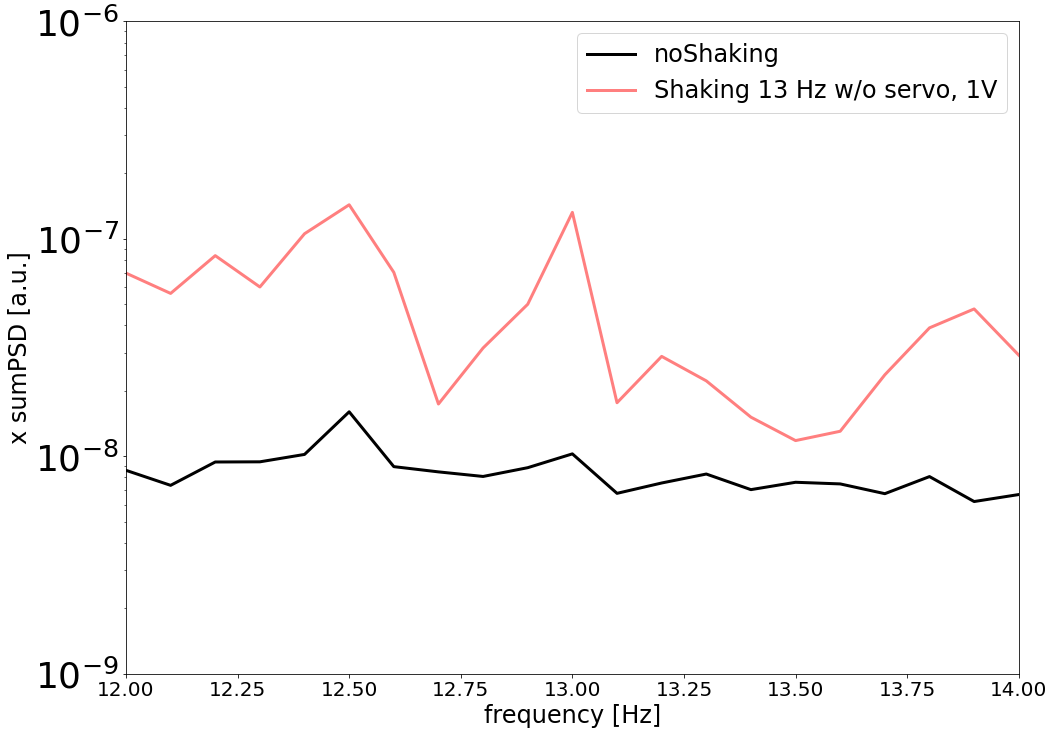

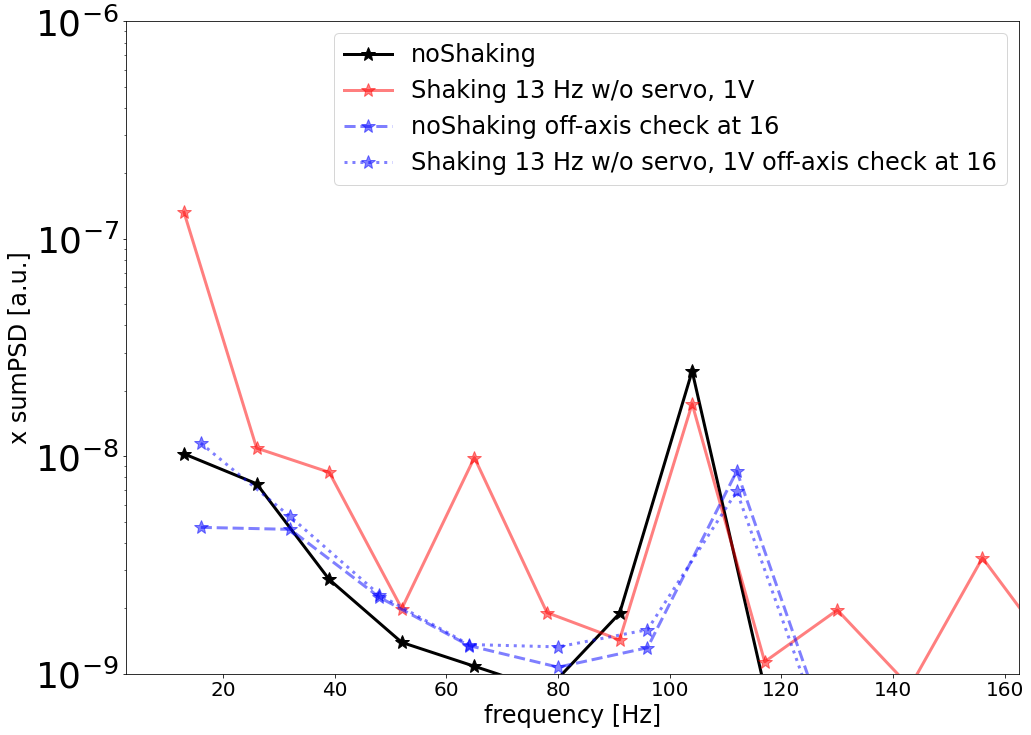

In [172]:
plotQuick(13,df_1=df_NoShaking,df_2=df_Shaking13Hz1V,label1="noShaking",label2="Shaking 13 Hz w/o servo, 1V",offset=3,scaleFactor=2,lowylim=1e-9,upylim=1e-6,lowxlim=12,upxlim=14)

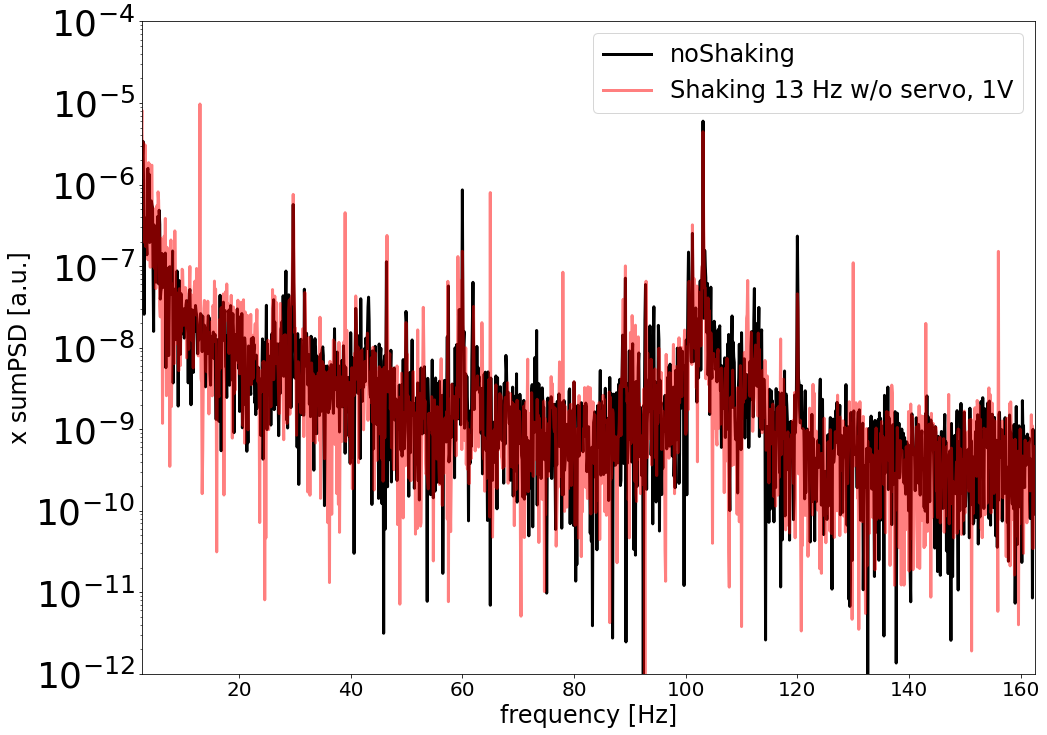

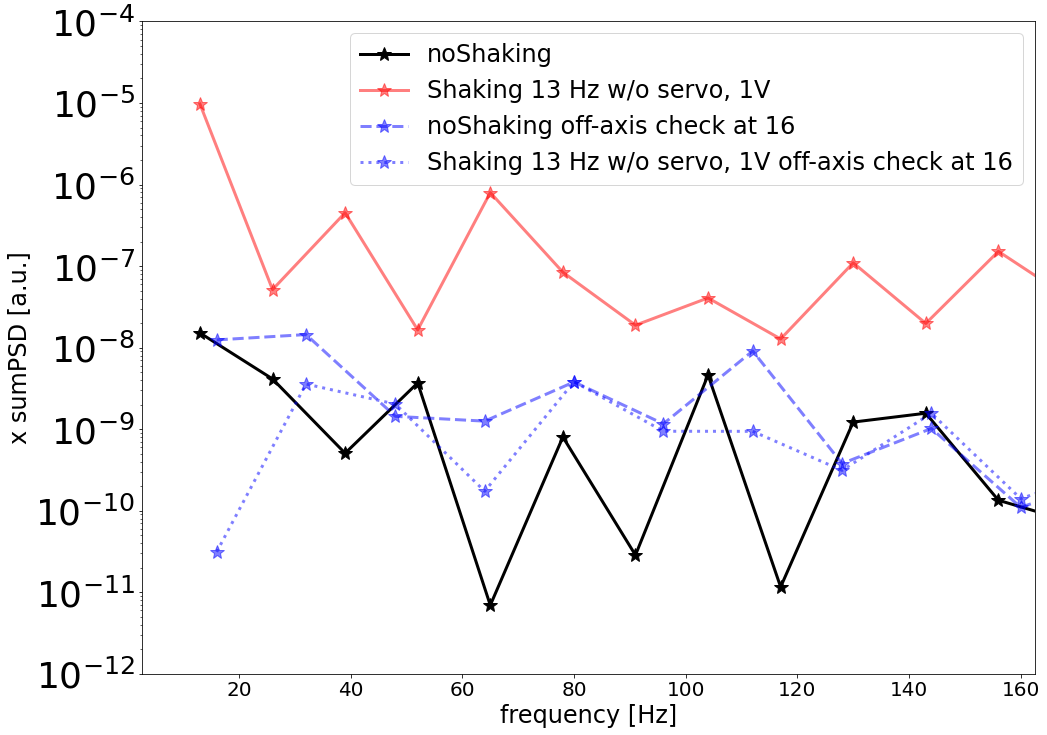

In [141]:
fundamental=13
plotQuickAlternatemethod(fundamental,df_1=df_NoShaking,df_2=df_Shaking13Hz1V,label1="noShaking",label2="Shaking 13 Hz w/o servo, 1V",offset=3,scaleFactor=2,lowylim=1e-12)

In [83]:
folderName="/data/new_trap/20220502/Bead0/VibrationTest/ShakingNoServo3Hz/"
filePrefix="Shaking"
#files = load_dir_sorted(folderName,file_prefix=filePrefix,start_file=0,max_file=1000)
freqs,df_Shaking3HzNoServo = extract_data_to_df(folderName,filePrefix,filterStd=True)
print(len(df_Shaking3HzNoServo))

  0%|          | 0/20 [00:00<?, ?it/s]

100


100%|██████████| 20/20 [00:00<00:00, 29.90it/s]


100


In [90]:
print(voltage_to_x_position(df_Shaking3HzNoServo["cantPosY"][0].max()-df_Shaking3HzNoServo["cantPosY"][0].min()))

139.64642038021393


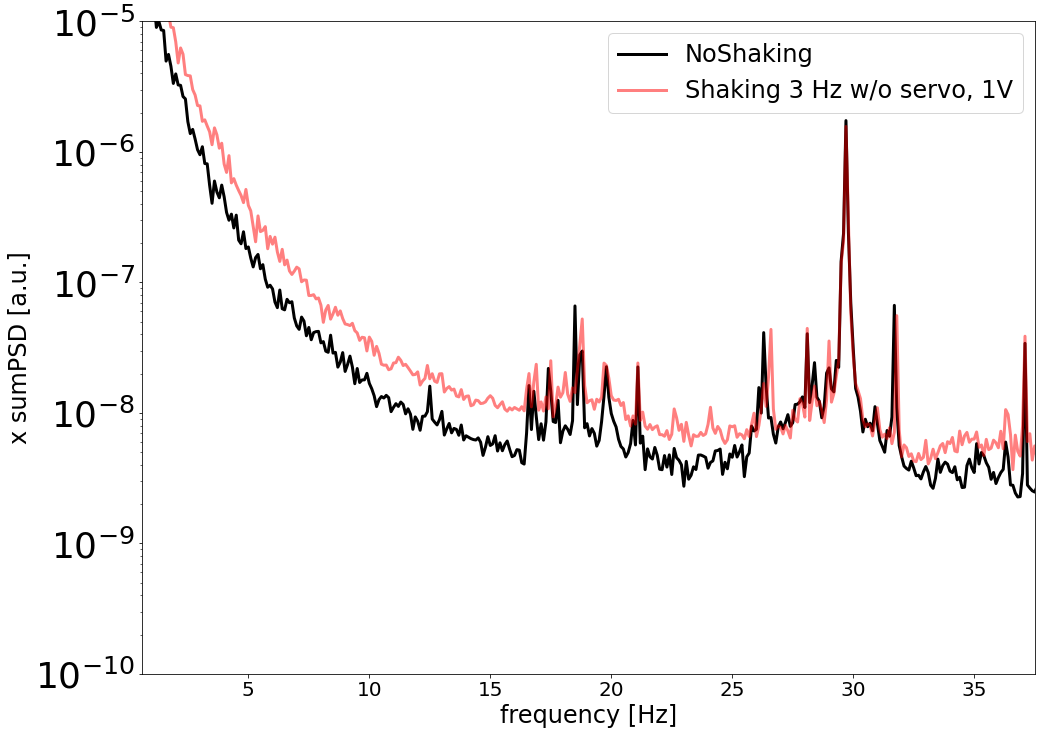

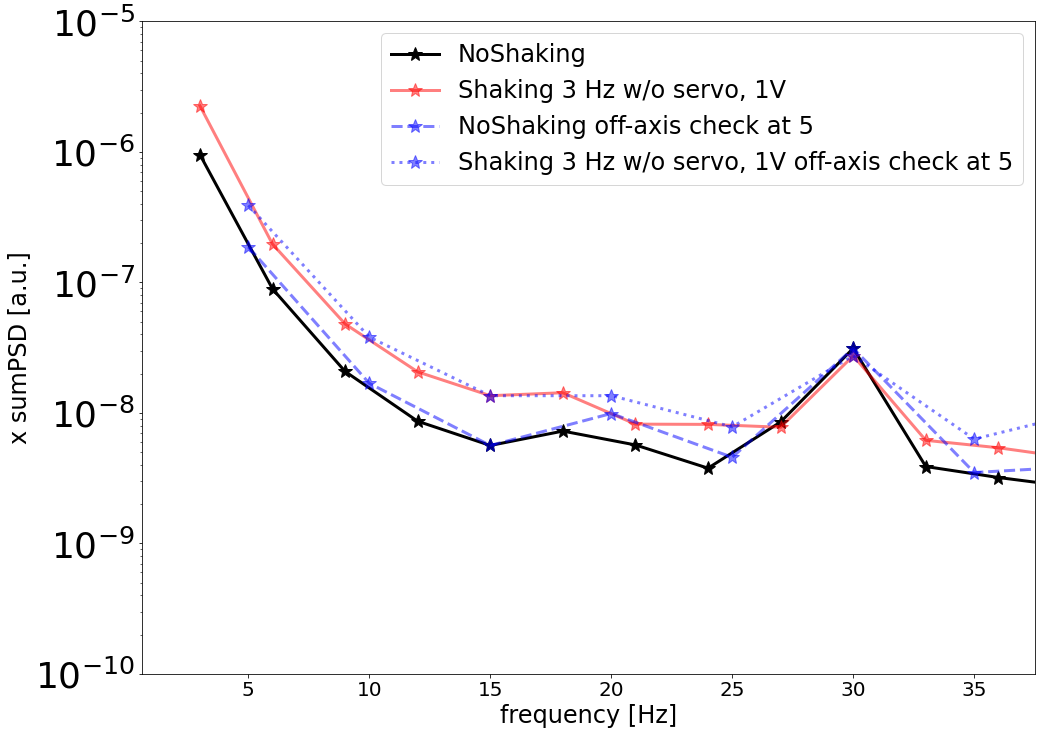

In [142]:
fundamental=3
plotQuick(fundamental,df_1=df_NoShaking,df_2=df_Shaking3HzNoServo,label1="NoShaking",label2="Shaking 3 Hz w/o servo, 1V",offset=2,scaleFactor=2,upylim=1e-5)

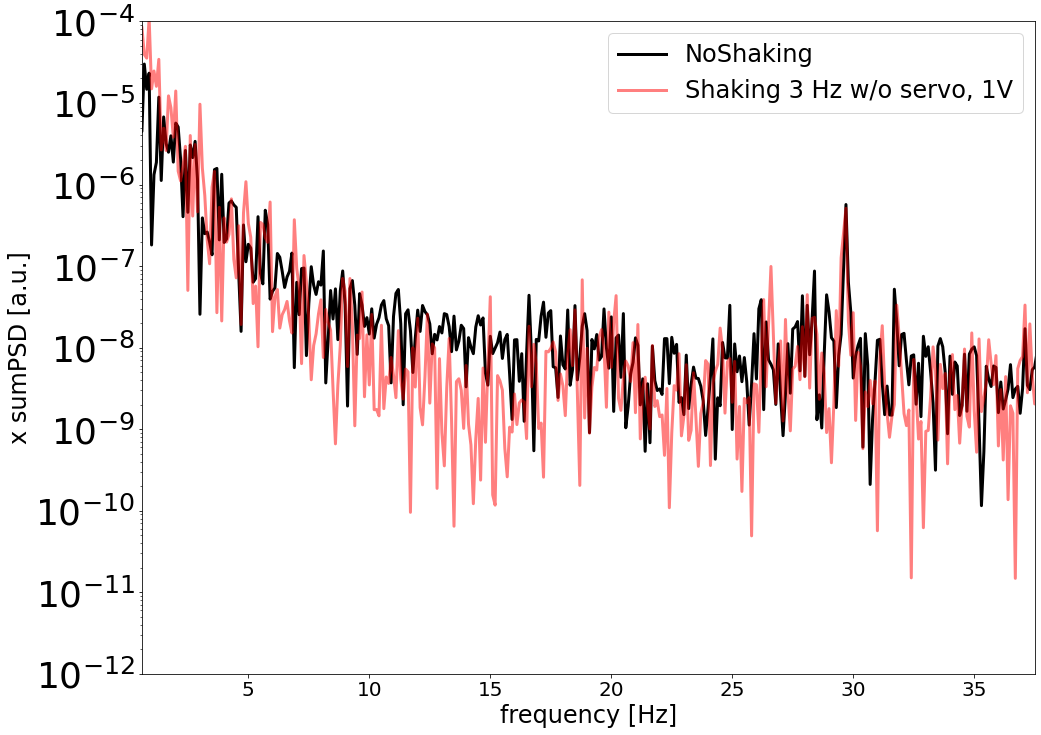

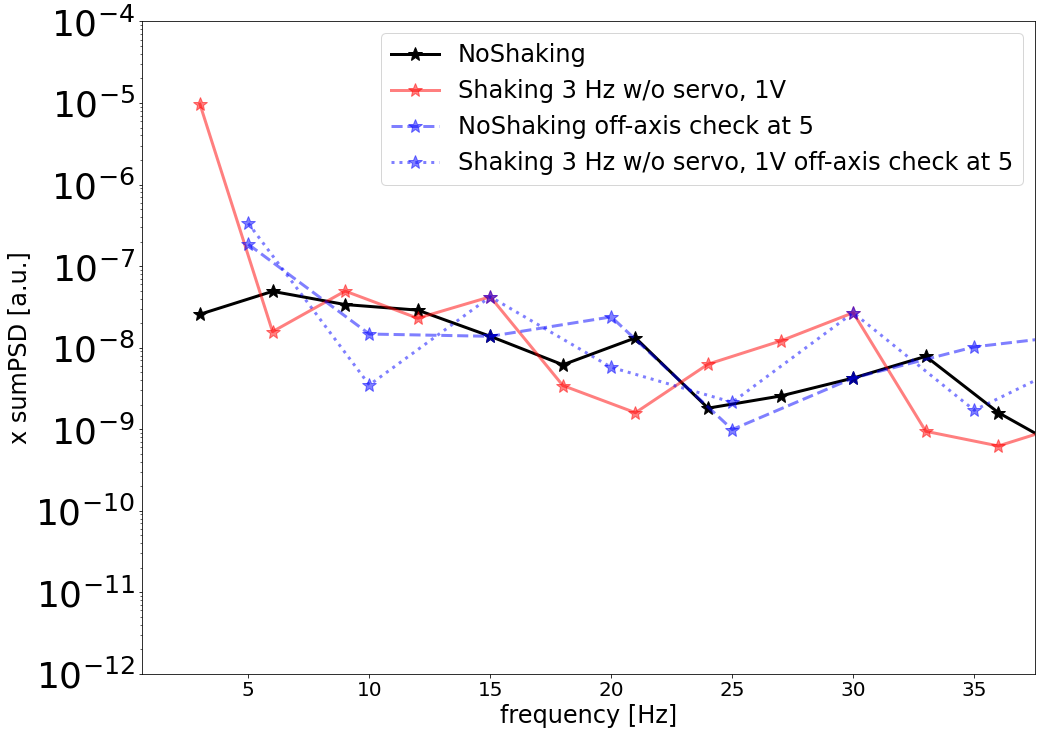

In [144]:
fundamental=3
plotQuickAlternatemethod(fundamental,df_1=df_NoShaking,df_2=df_Shaking3HzNoServo,label1="NoShaking",label2="Shaking 3 Hz w/o servo, 1V",offset=2,scaleFactor=2,upylim=1e-4,lowylim=1e-12)

In [100]:
folderName="/data/new_trap/20220502/Bead0/VibrationTest/ShakingServo3Hz/"
filePrefix="Shaking"
#files = load_dir_sorted(folderName,file_prefix=filePrefix,start_file=0,max_file=1000)
freqs,df_Shaking3HzServo = extract_data_to_df(folderName,filePrefix,filterStd=True)
print(len(df_Shaking3HzServo))

  0%|          | 0/20 [00:00<?, ?it/s]

1000


100%|██████████| 20/20 [00:06<00:00,  3.01it/s]


999


In [111]:
print(voltage_to_x_position(df_Shaking3HzServo["cantPosY"][0].max()-df_Shaking3HzServo["cantPosY"][0].min()))

202.2964141612942


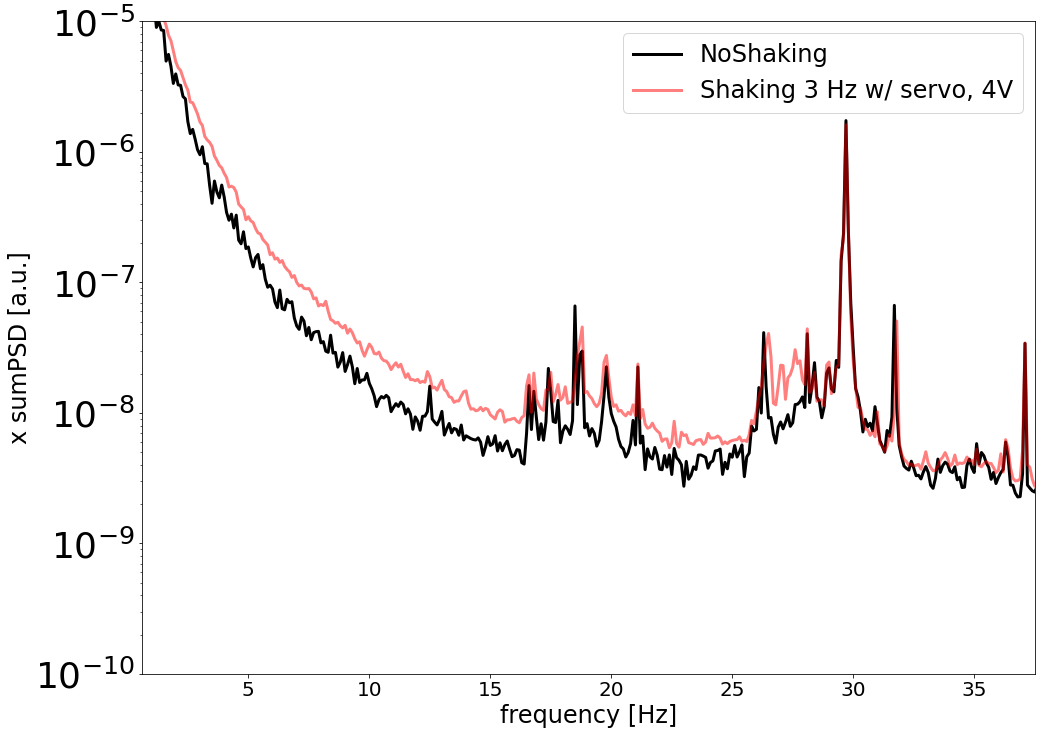

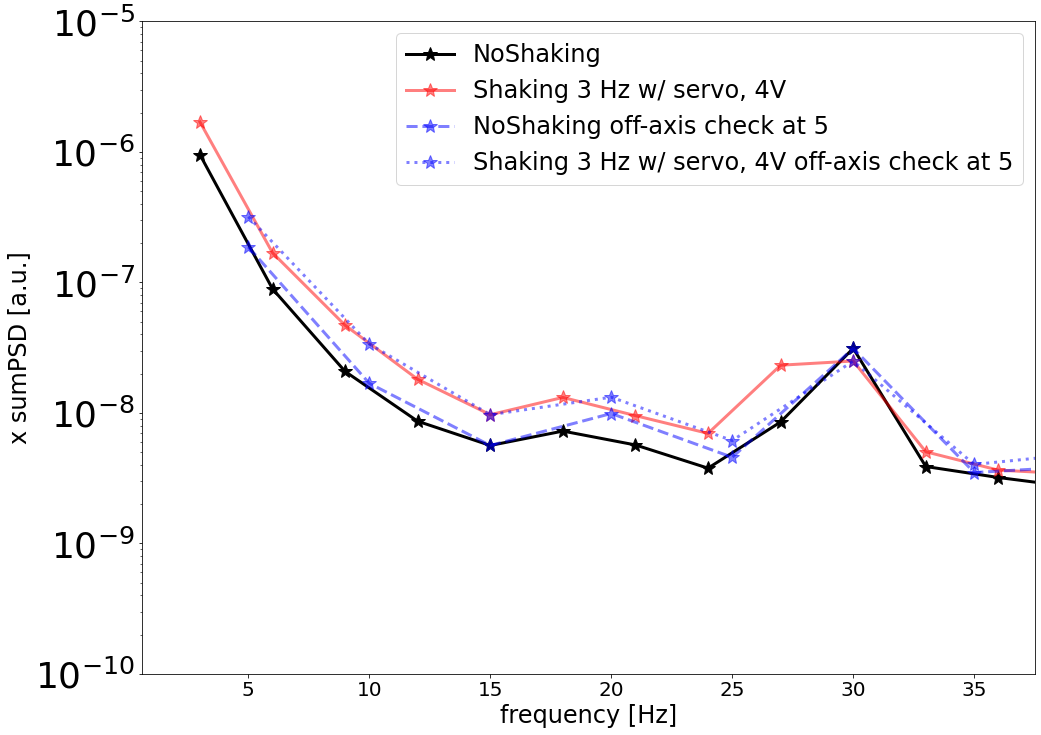

In [114]:
fundamental=3
plotQuick(fundamental,df_1=df_NoShaking,df_2=df_Shaking3HzServo,label1="NoShaking",label2="Shaking 3 Hz w/ servo, 4V",offset=2,scaleFactor=20,upylim=1e-5)

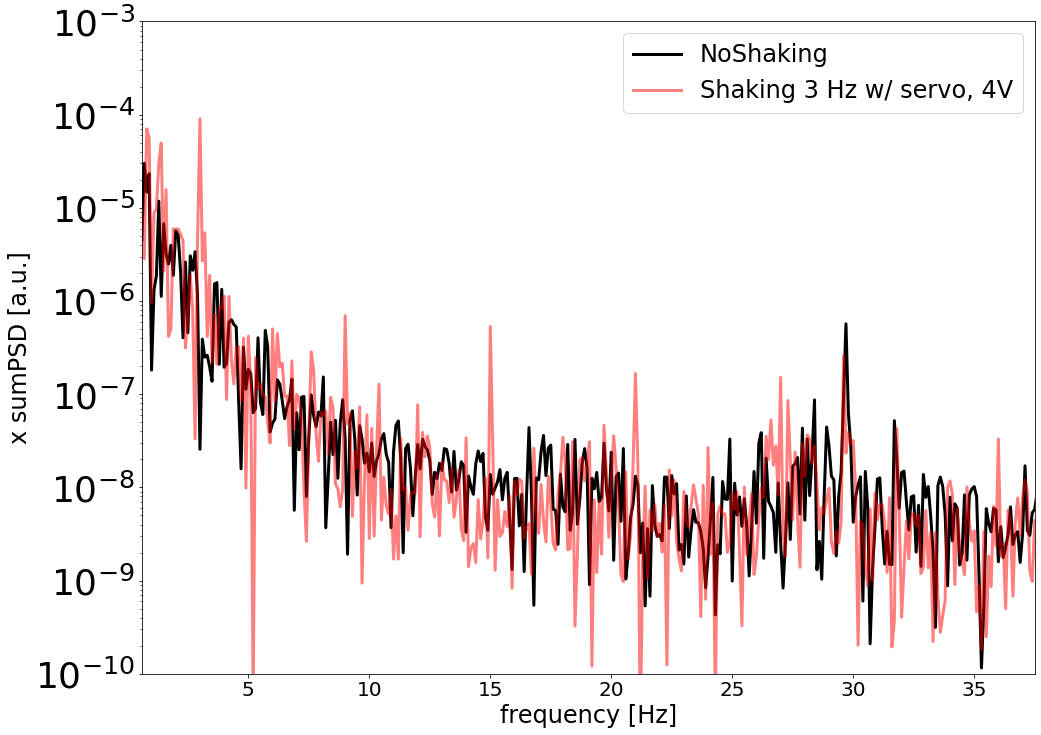

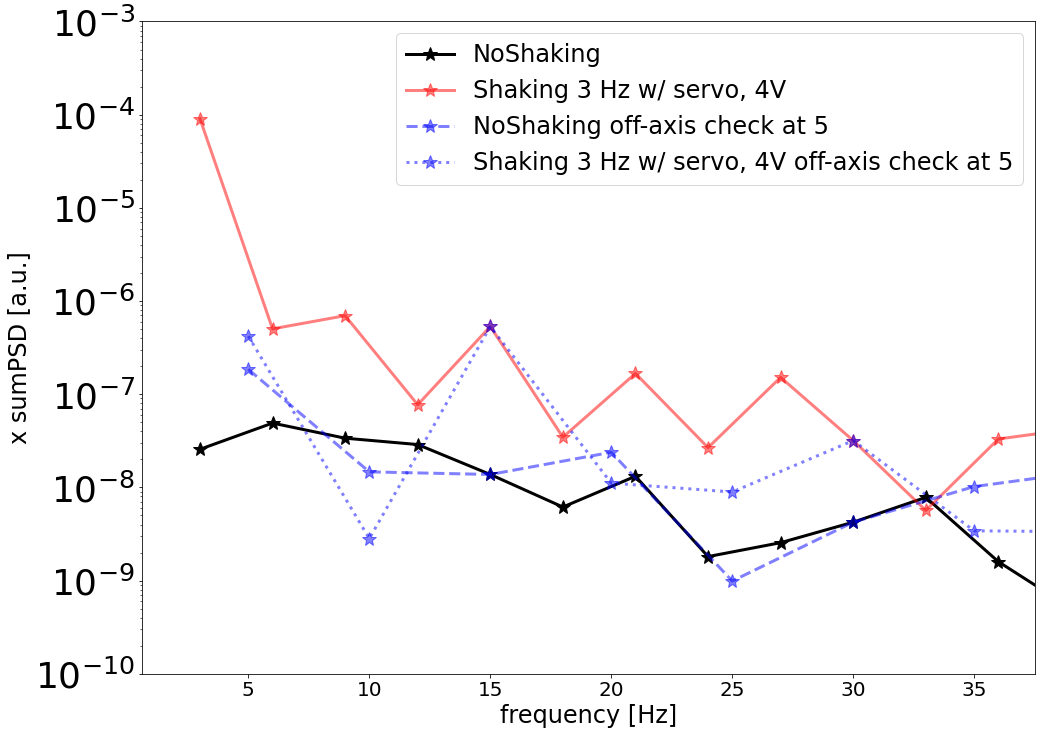

In [145]:
fundamental=3
plotQuickAlternatemethod(fundamental,df_1=df_NoShaking,df_2=df_Shaking3HzServo,label1="NoShaking",label2="Shaking 3 Hz w/ servo, 4V",offset=2,scaleFactor=20,upylim=1e-3)

# 2022/05/26

In [124]:
folderName="/data/new_trap/20220525/Bead00/NoShaking//"
filePrefix="NoShaking"
#files = load_dir_sorted(folderName,file_prefix=filePrefix,start_file=0,max_file=1000)
freqs,df_NoShaking_20220526 = extract_data_to_df(folderName,filePrefix,maxFiles=1000,filterStd=True)
print(len(df_NoShaking_20220526))

  0%|          | 0/20 [00:00<?, ?it/s]

1000


100%|██████████| 20/20 [00:06<00:00,  3.01it/s]


957


In [125]:
folderName="/data/new_trap/20220525/Bead00/Shaking/13Hz/NoServo/1//"
filePrefix="Shaking"
#files = load_dir_sorted(folderName,file_prefix=filePrefix,start_file=0,max_file=1000)
freqs,df_Shaking13HzNoServo_20220526 = extract_data_to_df(folderName,filePrefix,filterStd=True)
print(len(df_Shaking13HzNoServo_20220526))

  0%|          | 0/20 [00:00<?, ?it/s]

100


100%|██████████| 20/20 [00:00<00:00, 23.18it/s]


99


In [149]:
folderName="/data/new_trap/20220525/Bead00/Shaking/13Hz/NoServo/2/"
filePrefix="Shaking"
#files = load_dir_sorted(folderName,file_prefix=filePrefix,start_file=0,max_file=1000)
freqs,df_Shaking13HzNoServo_20220526_2 = extract_data_to_df(folderName,filePrefix,filterStd=True)
print(len(df_Shaking13HzNoServo_20220526_2))

  0%|          | 0/20 [00:00<?, ?it/s]

100


100%|██████████| 20/20 [00:04<00:00,  4.36it/s]


100


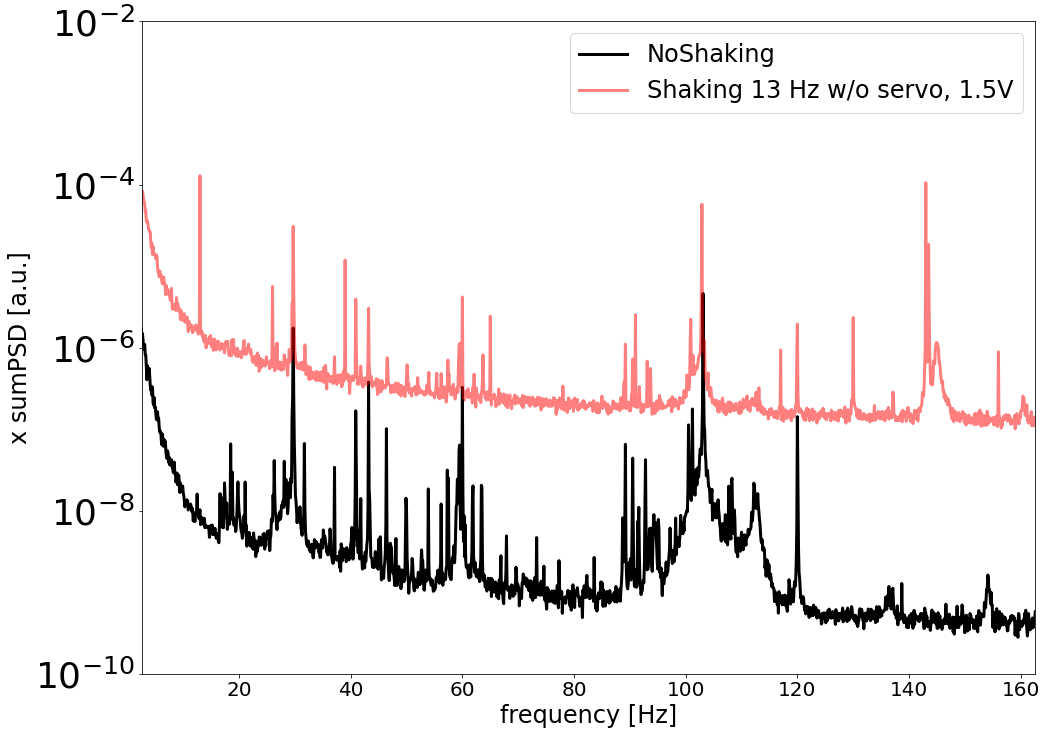

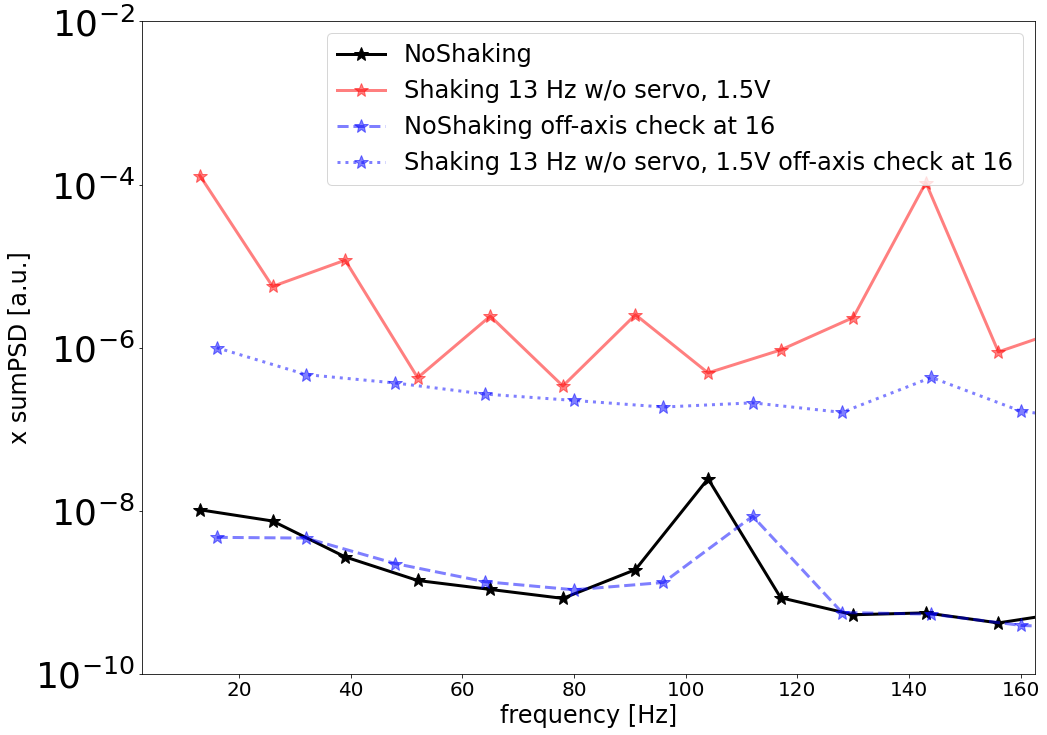

In [126]:
fundamental=13
plotQuick(fundamental,df_1=df_NoShaking,df_2=df_Shaking13HzNoServo_20220526,label1="NoShaking",label2="Shaking 13 Hz w/o servo, 1.5V",offset=3,scaleFactor=1/10,upylim=1e-2)

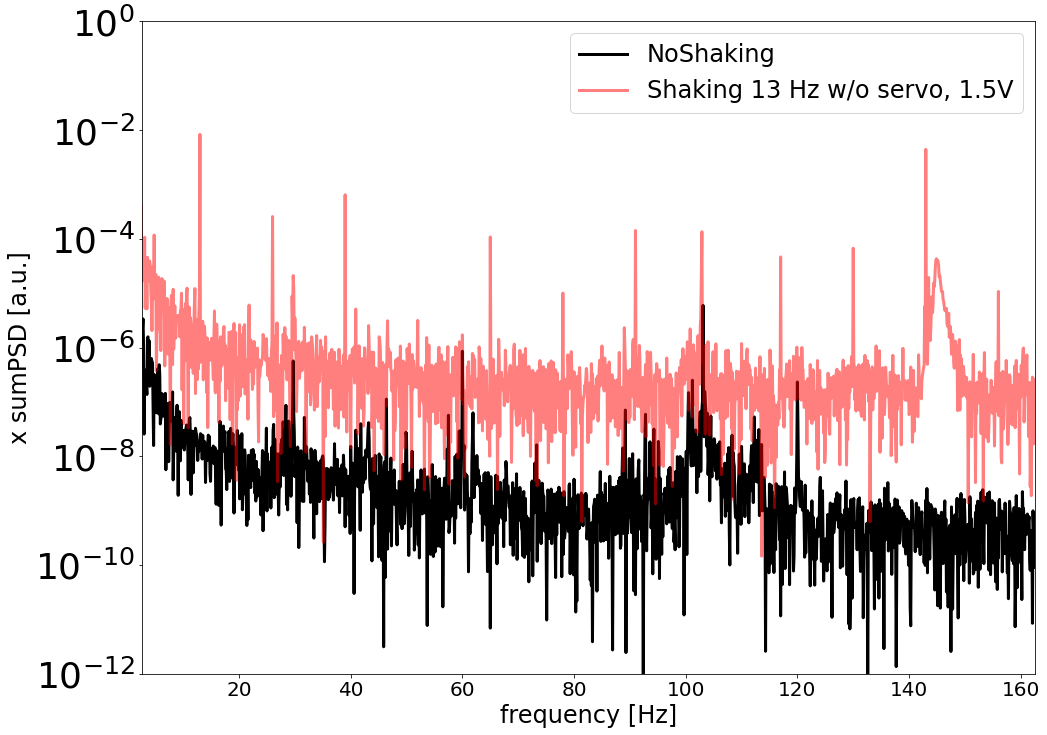

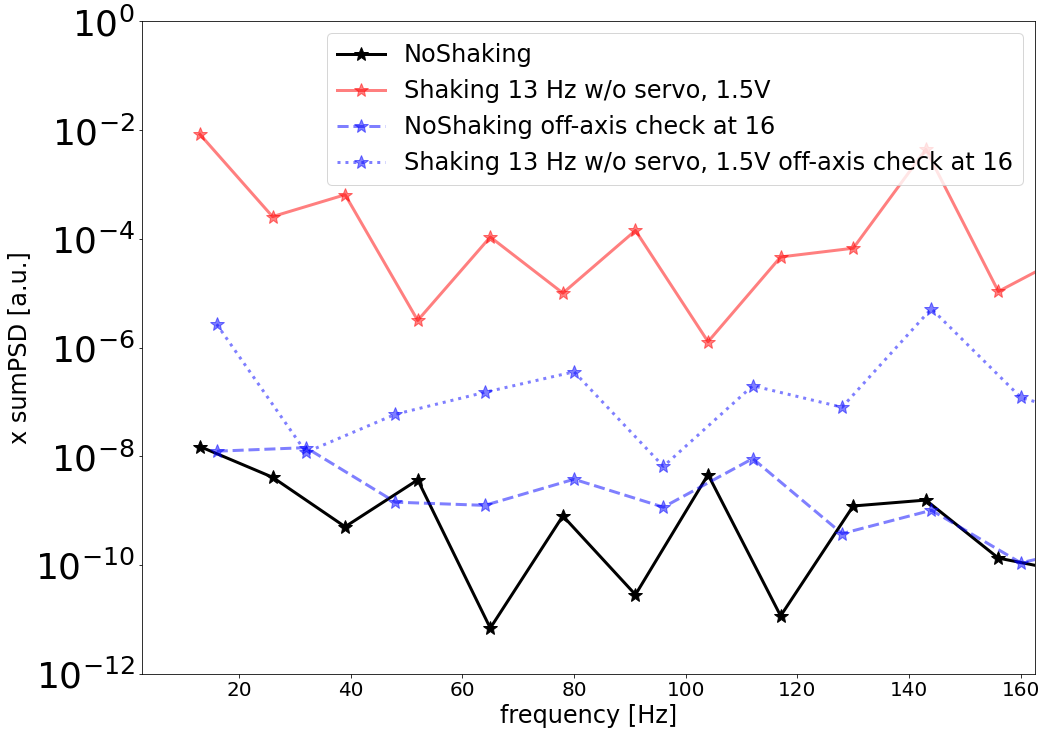

In [148]:
fundamental=13
plotQuickAlternatemethod(fundamental,df_1=df_NoShaking,df_2=df_Shaking13HzNoServo_20220526,label1="NoShaking",label2="Shaking 13 Hz w/o servo, 1.5V",offset=3,scaleFactor=1/10,upylim=1,lowylim=1e-12)

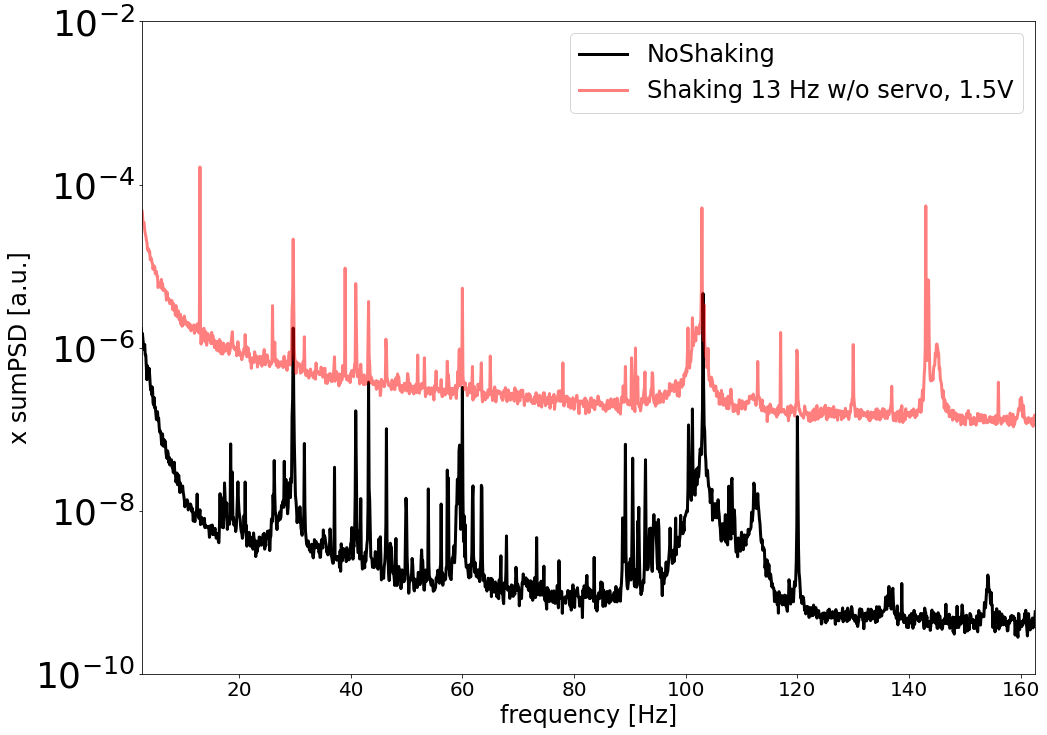

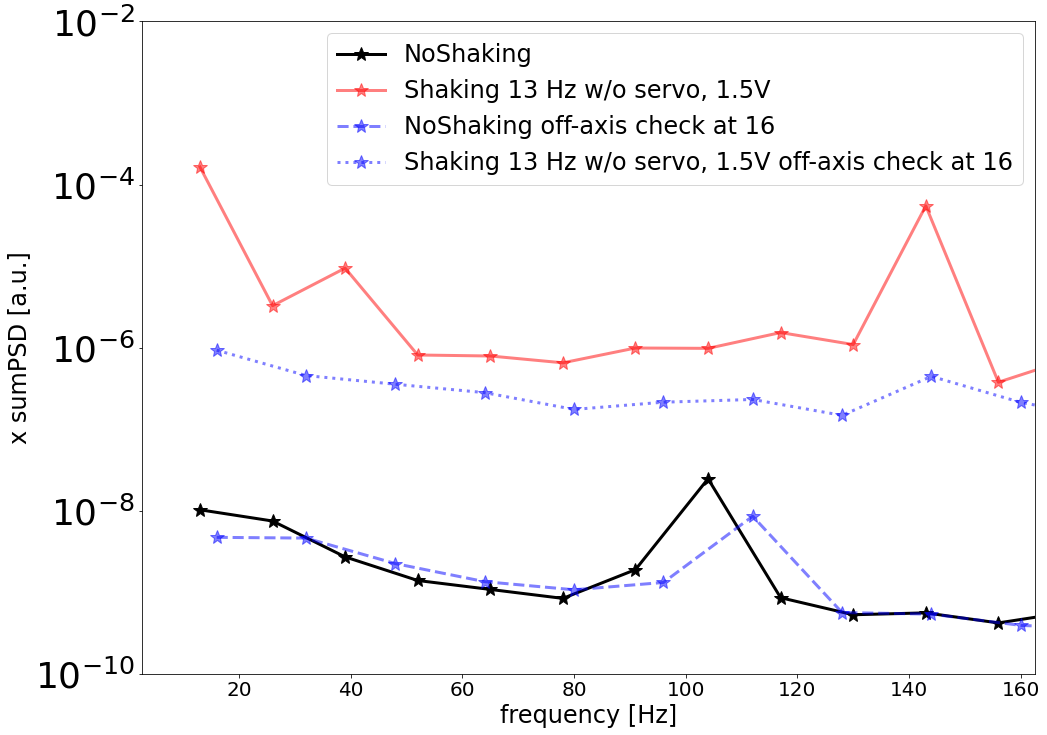

In [150]:
fundamental=13
plotQuick(fundamental,df_1=df_NoShaking,df_2=df_Shaking13HzNoServo_20220526_2,label1="NoShaking",label2="Shaking 13 Hz w/o servo, 1.5V",offset=3,scaleFactor=1/10,upylim=1e-2)

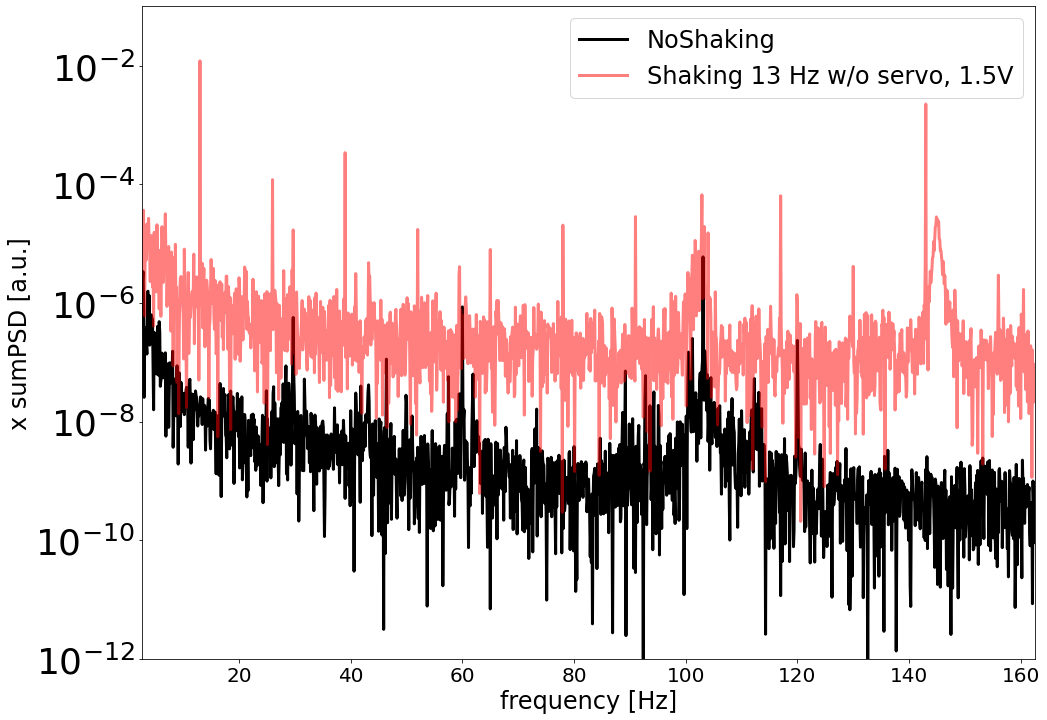

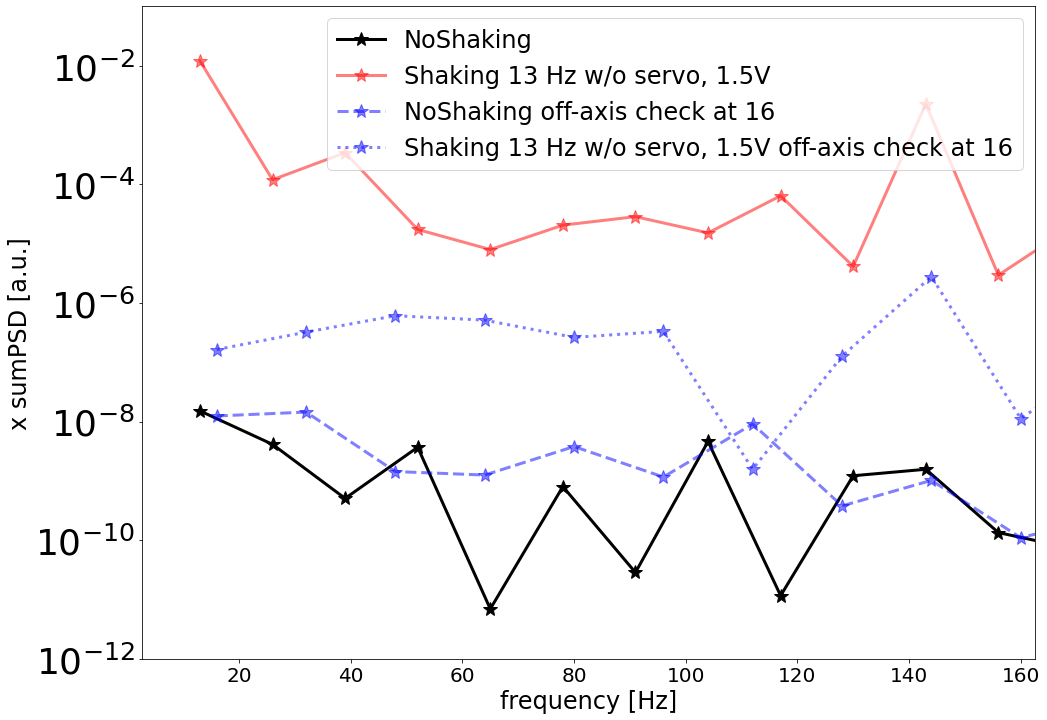

In [157]:
fundamental=13
plotQuickAlternatemethod(fundamental,df_1=df_NoShaking,df_2=df_Shaking13HzNoServo_20220526_2,label1="NoShaking",label2="Shaking 13 Hz w/o servo, 1.5V",offset=3,scaleFactor=1/10,upylim=1e-1,lowylim=1e-12)
             

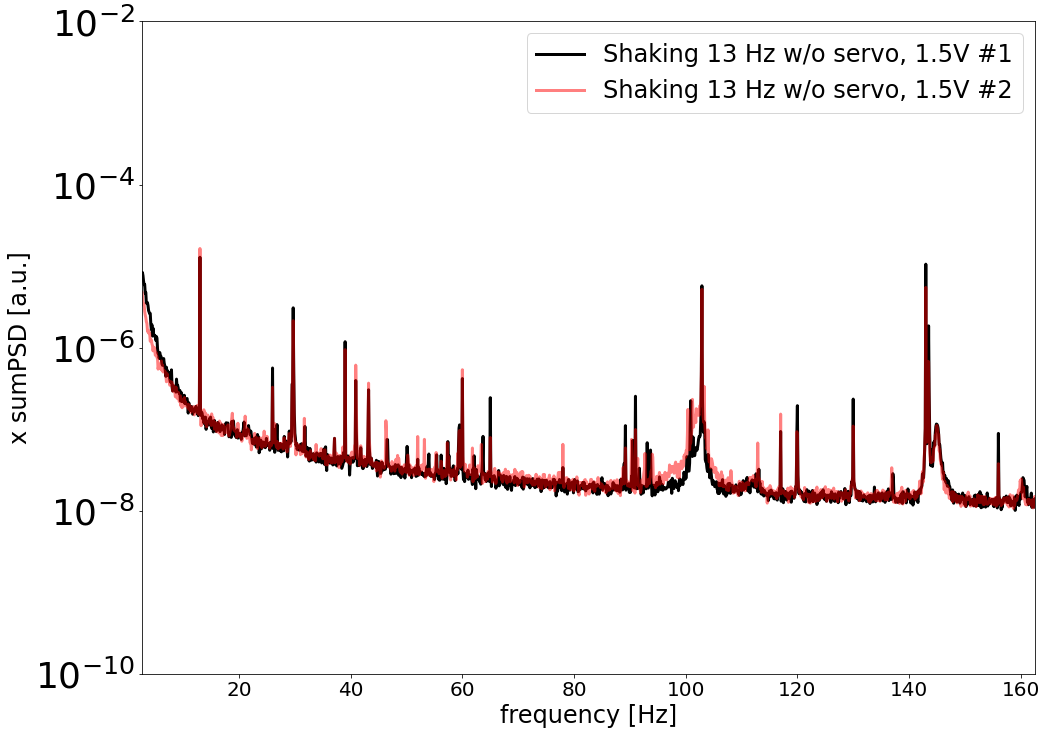

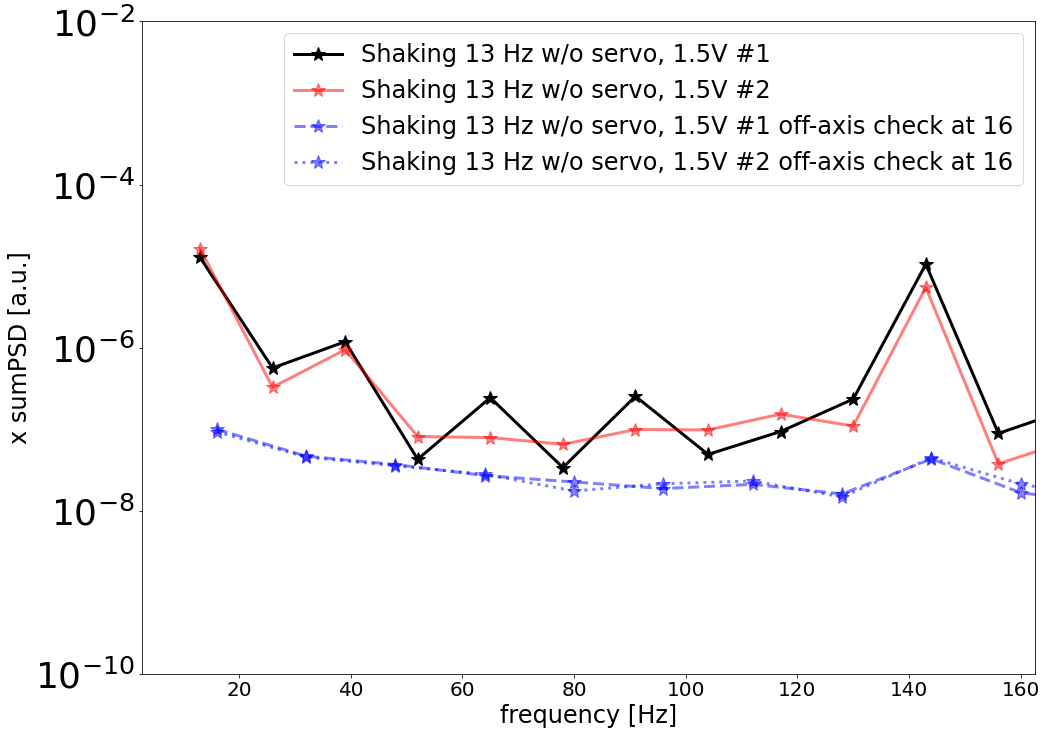

In [153]:
plotQuick(fundamental,df_1=df_Shaking13HzNoServo_20220526,df_2=df_Shaking13HzNoServo_20220526_2,label1="Shaking 13 Hz w/o servo, 1.5V #1",label2="Shaking 13 Hz w/o servo, 1.5V #2",offset=3,scaleFactor=1,upylim=1e-2)

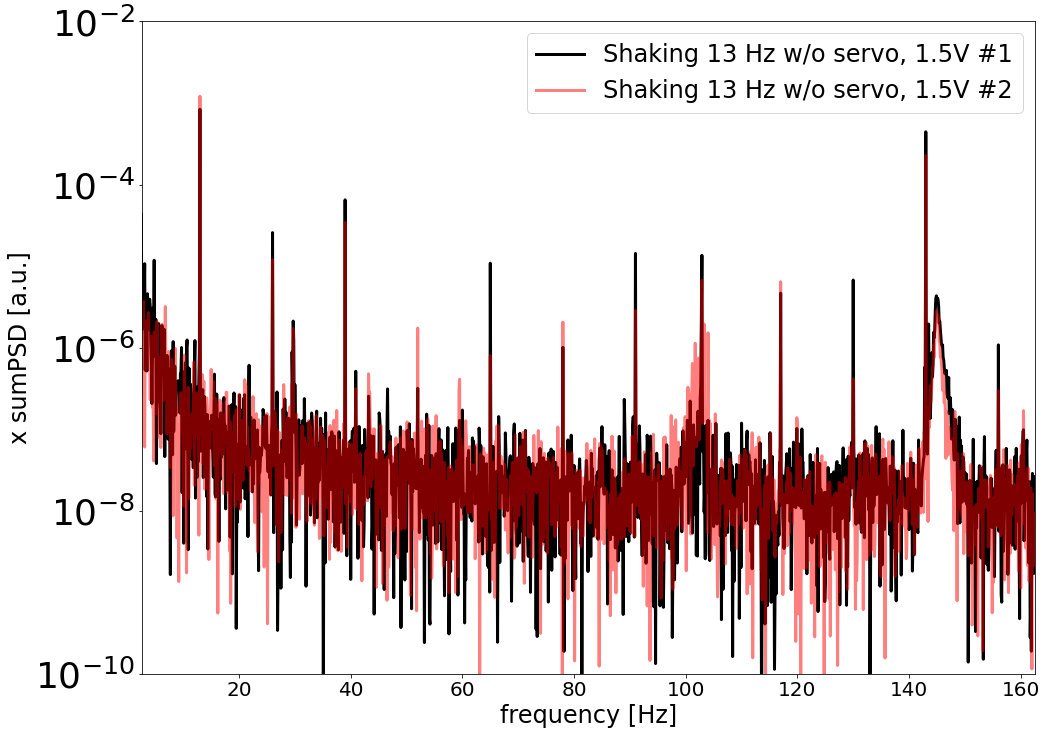

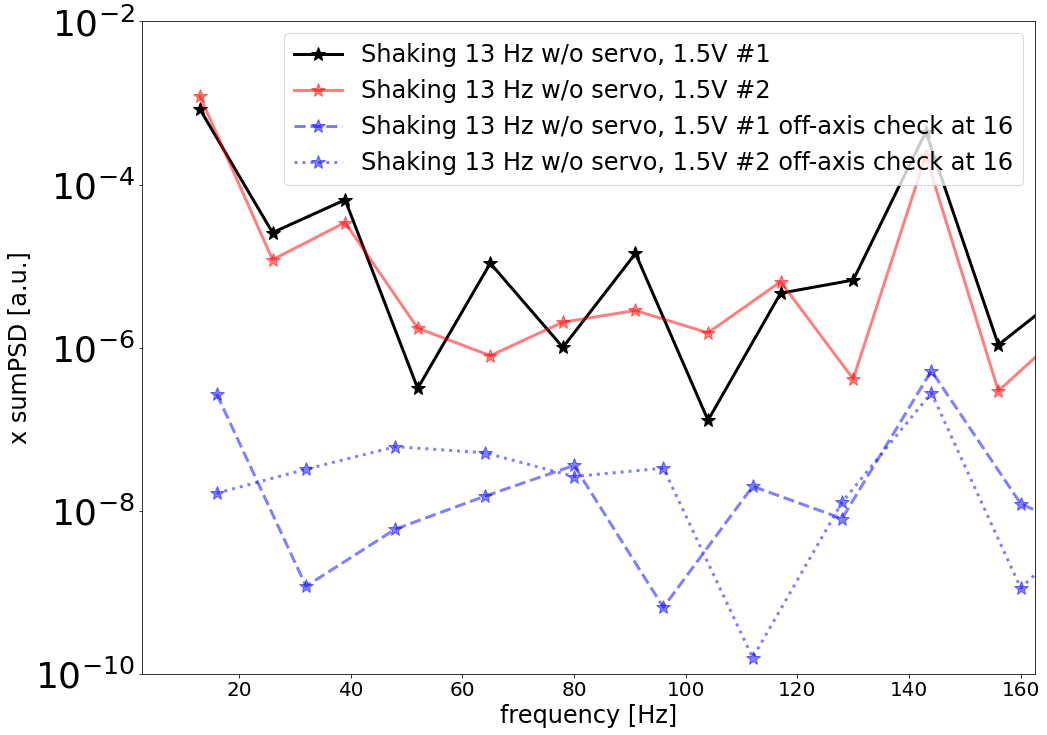

In [155]:
plotQuickAlternatemethod(fundamental,df_1=df_Shaking13HzNoServo_20220526,df_2=df_Shaking13HzNoServo_20220526_2,label1="Shaking 13 Hz w/o servo, 1.5V #1",label2="Shaking 13 Hz w/o servo, 1.5V #2",offset=3,scaleFactor=1,upylim=1e-2)

In [158]:
print(voltage_to_x_position(df_Shaking13HzNoServo_20220526_2["cantPosY"][0].max()-df_Shaking13HzNoServo_20220526_2["cantPosY"][0].min()))

217.48949696376738


In [159]:
folderName="/data/new_trap/20220526/Bead0/NoShaking/1/"
filePrefix="NoShaking"
#files = load_dir_sorted(folderName,file_prefix=filePrefix,start_file=0,max_file=1000)
freqs,df_NoShaking_20220526_1 = extract_data_to_df(folderName,filePrefix,maxFiles=1000,filterStd=True)
print(len(df_NoShaking_20220526_1))

  0%|          | 0/20 [00:00<?, ?it/s]

1000


100%|██████████| 20/20 [00:47<00:00,  2.39s/it]


1000


In [8]:
folderName="/data/new_trap/20220526/Bead0/Shaking/13Hz/NoServo/1/"
filePrefix="Shaking"
#files = load_dir_sorted(folderName,file_prefix=filePrefix,start_file=0,max_file=1000)
freqs,df_Shaking13Hz_20220526_retracted = extract_data_to_df(folderName,filePrefix,maxFiles=1000,filterStd=True)
print(len(df_Shaking13Hz_20220526_retracted))

  0%|          | 0/20 [00:00<?, ?it/s]

1000


100%|██████████| 20/20 [00:46<00:00,  2.32s/it]


1000


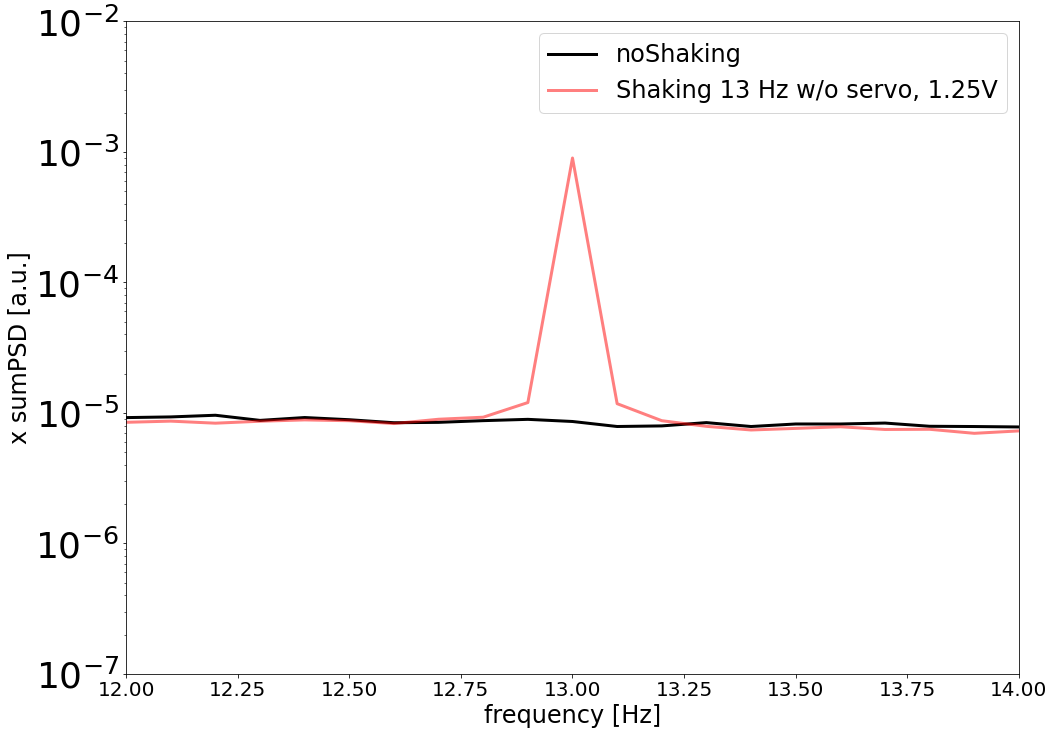

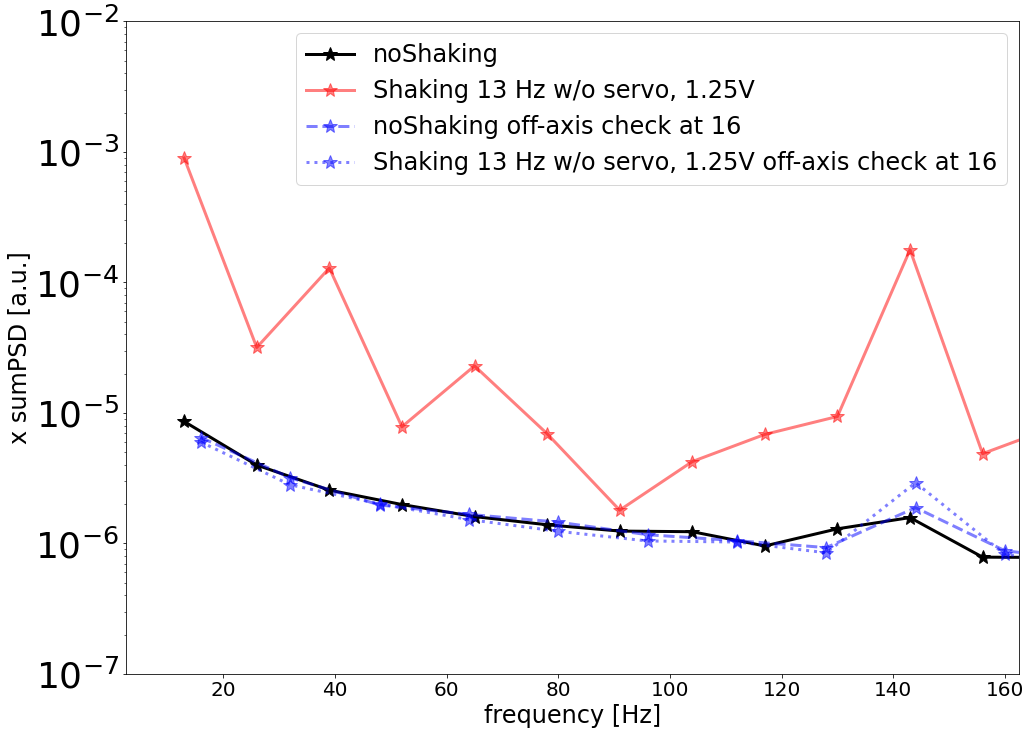

In [177]:
plotQuick(13,df_1=df_NoShaking_20220526_1,df_2=df_Shaking13Hz_20220526_retracted,label1="noShaking",label2="Shaking 13 Hz w/o servo, 1.25V",offset=3,scaleFactor=1,lowylim=1e-7,upylim=1e-2,lowxlim=12,upxlim=14)

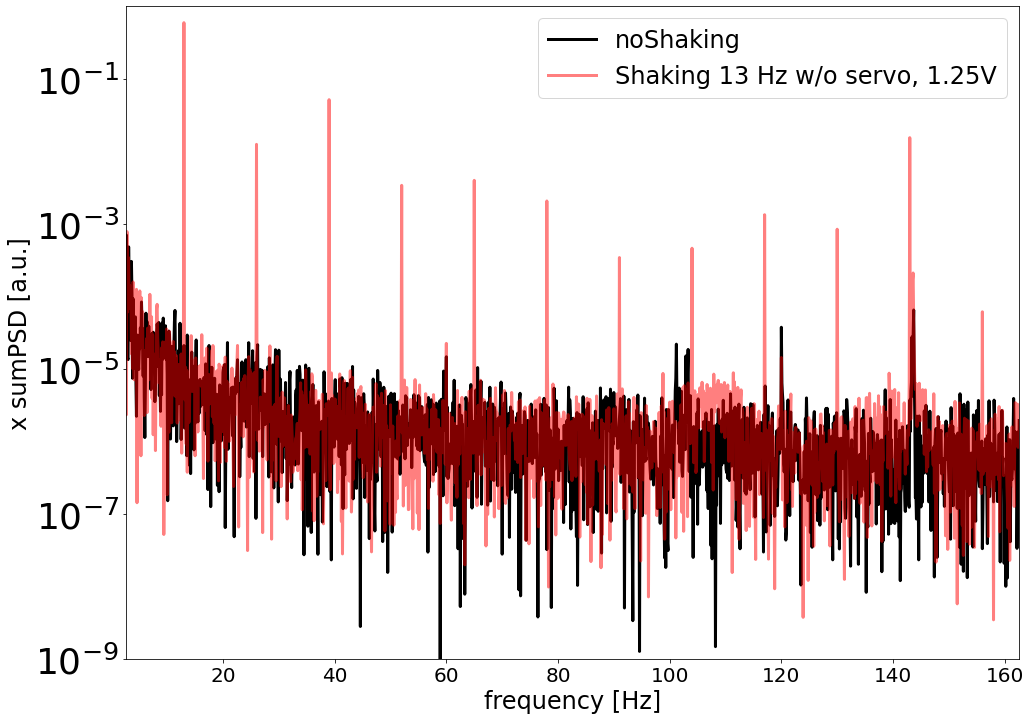

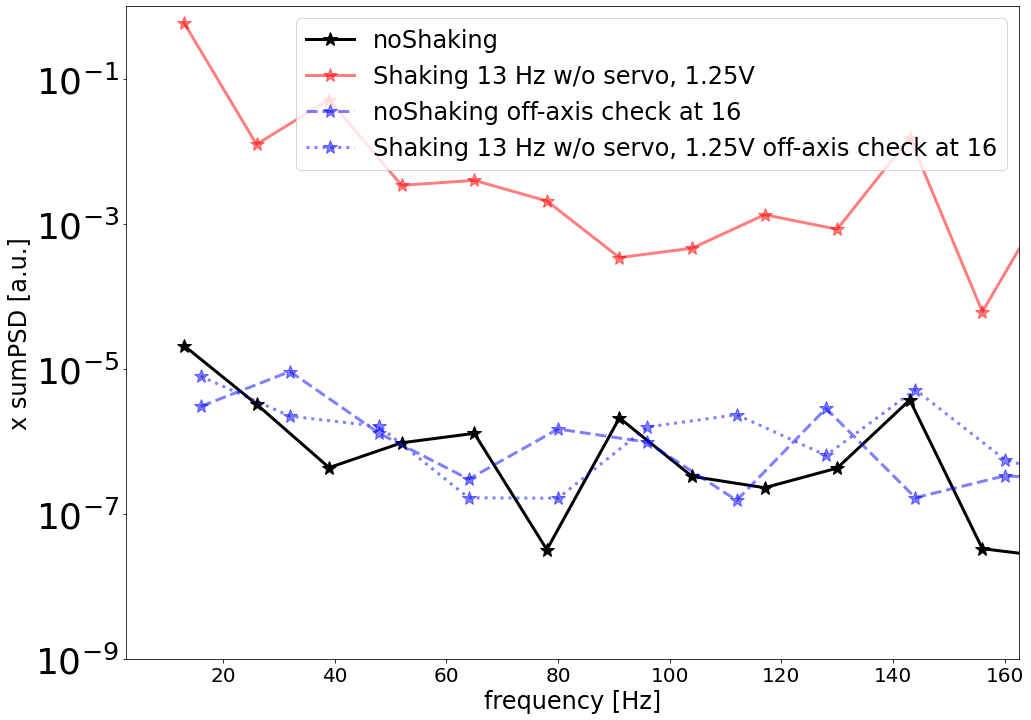

In [167]:
plotQuickAlternatemethod(13,df_1=df_NoShaking_20220526_1,df_2=df_Shaking13Hz_20220526_retracted,label1="noShaking",label2="Shaking 13 Hz w/o servo, 1.25V",offset=3,scaleFactor=1,lowylim=1e-9,upylim=1)

In [298]:
folderName="/data/new_trap/20220526/Bead0/Shaking/13Hz/NoServo/6/"
filePrefix="Shaking"
#files = load_dir_sorted(folderName,file_prefix=filePrefix,start_file=0,max_file=1000)
freqs,df_Shaking13Hz_20220526_retracted = extract_data_to_df(folderName,filePrefix,maxFiles=1000,filterStd=True)
print(len(df_Shaking13Hz_20220526_retracted))

  0%|          | 0/20 [00:00<?, ?it/s]

1000


100%|██████████| 20/20 [00:37<00:00,  1.07s/it]


1000


In [299]:
folderName="/data/new_trap/20220526/Bead0/NoShaking/3/"
#folderName="/data/new_trap/20220526/Bead0/Shaking/13Hz/NoServo/2/"

filePrefix="NoShaking"
#files = load_dir_sorted(folderName,file_prefix=filePrefix,start_file=0,max_file=1000)
freqs,df_NoShaking_20220526_1 = extract_data_to_df(folderName,filePrefix,maxFiles=1000,filterStd=True)
print(len(df_NoShaking_20220526_1))

  0%|          | 0/20 [00:00<?, ?it/s]

100


100%|██████████| 20/20 [00:00<00:00, 23.75it/s]


100


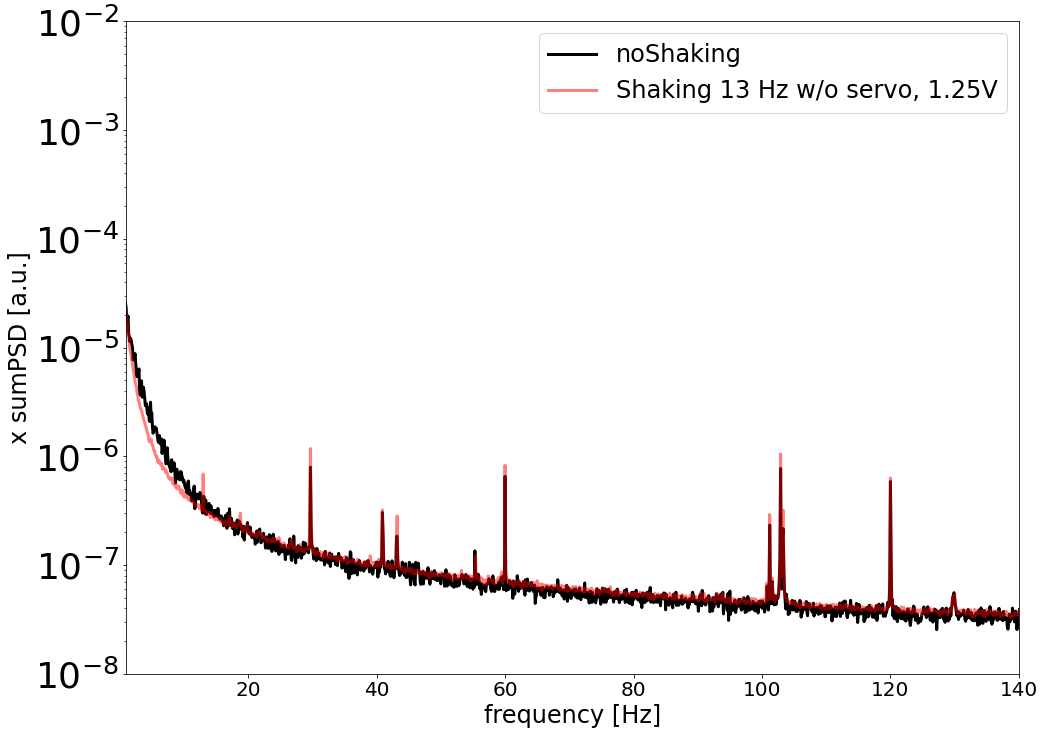

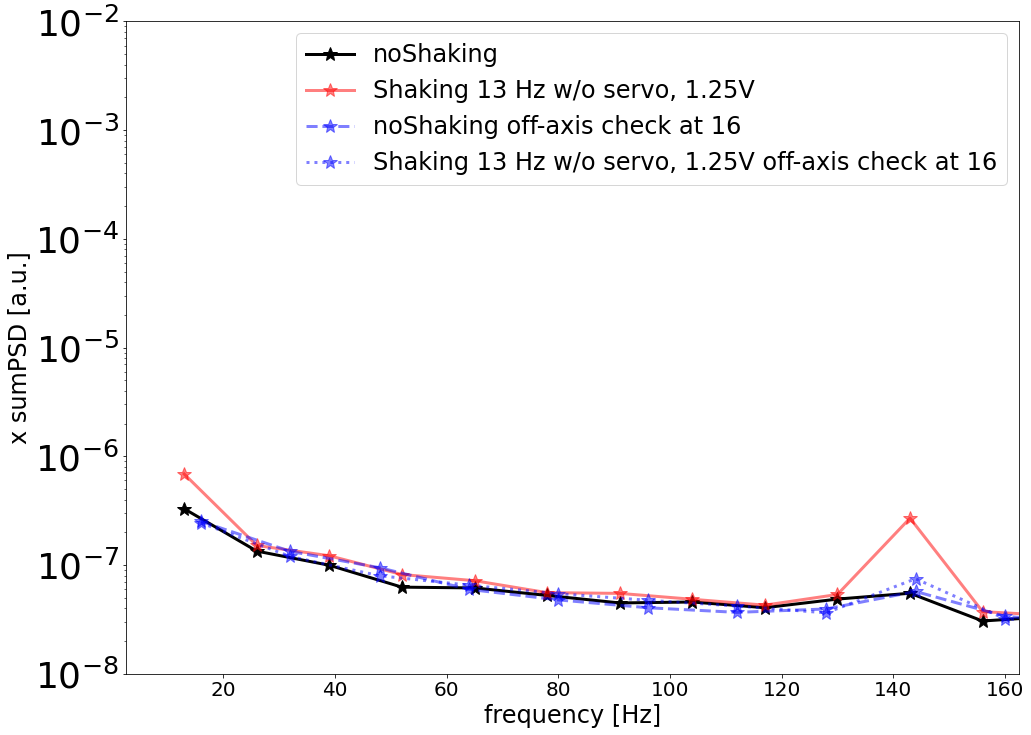

In [300]:
plotQuick(13,df_1=df_NoShaking_20220526_1,df_2=df_Shaking13Hz_20220526_retracted,label1="noShaking",label2="Shaking 13 Hz w/o servo, 1.25V",offset=3,scaleFactor=10,lowylim=1e-8,upylim=1e-2,lowxlim=1,upxlim=140)

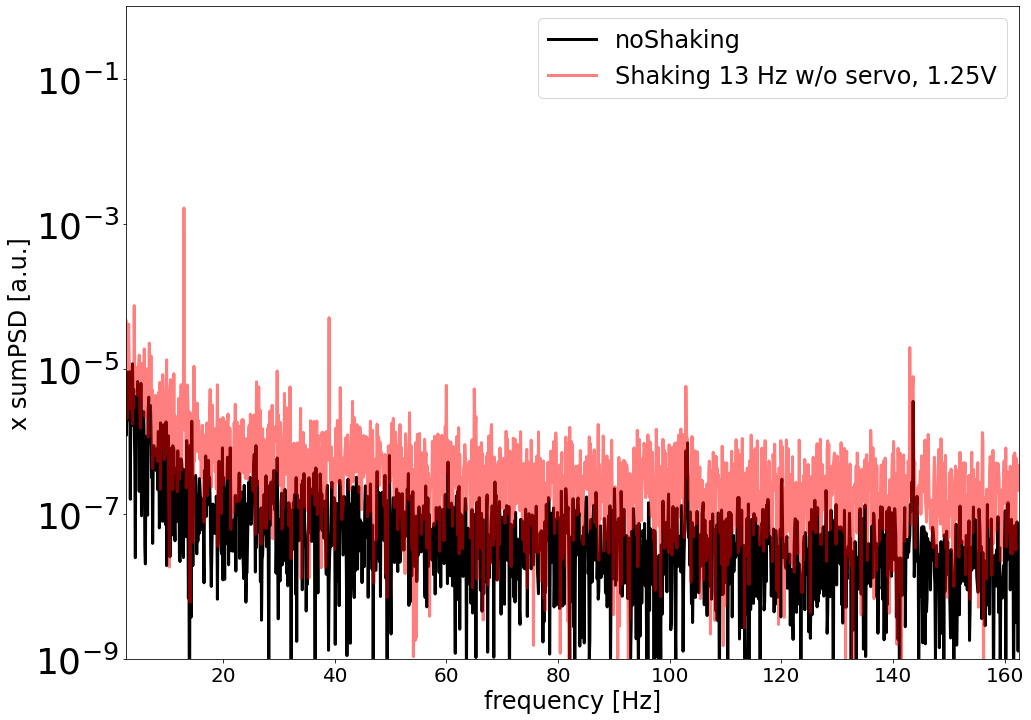

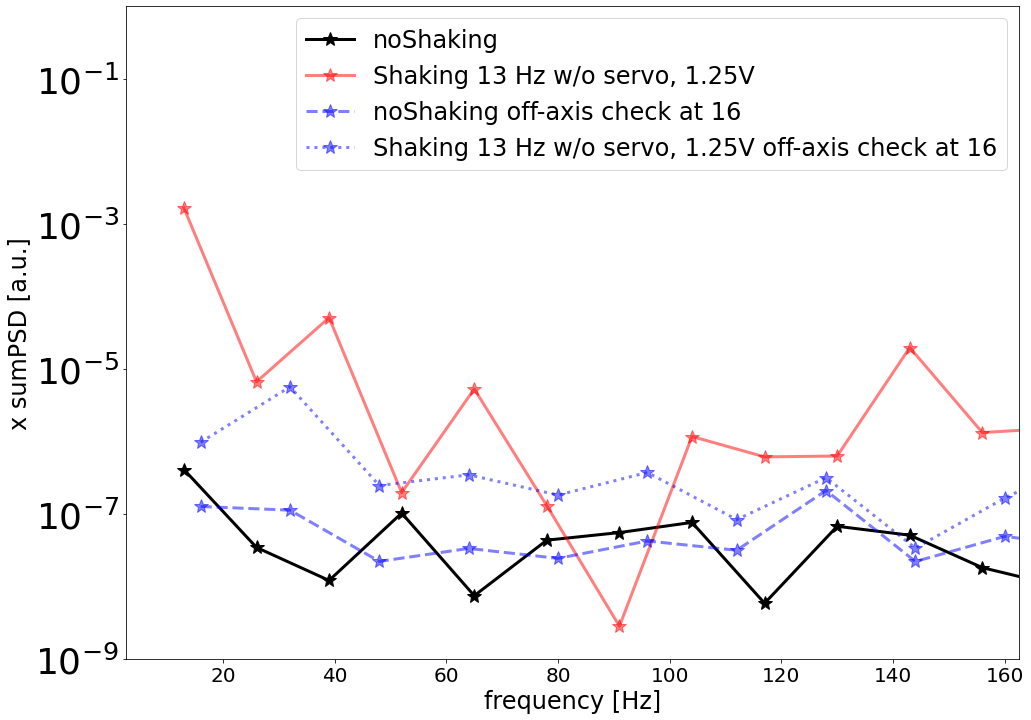

In [303]:
plotQuickAlternatemethod(13,df_1=df_NoShaking_20220526_1,df_2=df_Shaking13Hz_20220526_retracted,label1="noShaking",label2="Shaking 13 Hz w/o servo, 1.25V",offset=3,scaleFactor=100/69,lowylim=1e-9,upylim=1)


In [304]:
folderName="/data/new_trap/20220526/Bead0/Shaking/13Hz/NoServo/7/"
filePrefix="Shaking"
#files = load_dir_sorted(folderName,file_prefix=filePrefix,start_file=0,max_file=1000)
freqs,df_Shaking13Hz_20220526_retracted = extract_data_to_df(folderName,filePrefix,maxFiles=1000,filterStd=True)
print(len(df_Shaking13Hz_20220526_retracted))

  0%|          | 0/20 [00:00<?, ?it/s]

1000


100%|██████████| 20/20 [00:48<00:00,  2.31s/it]


996


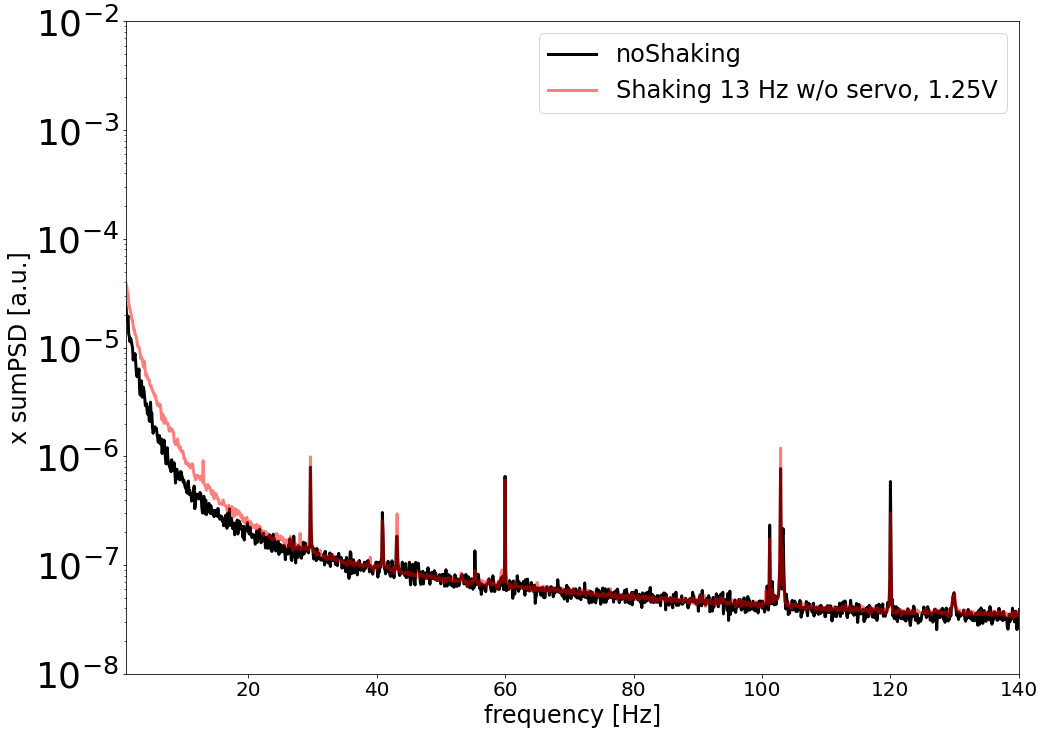

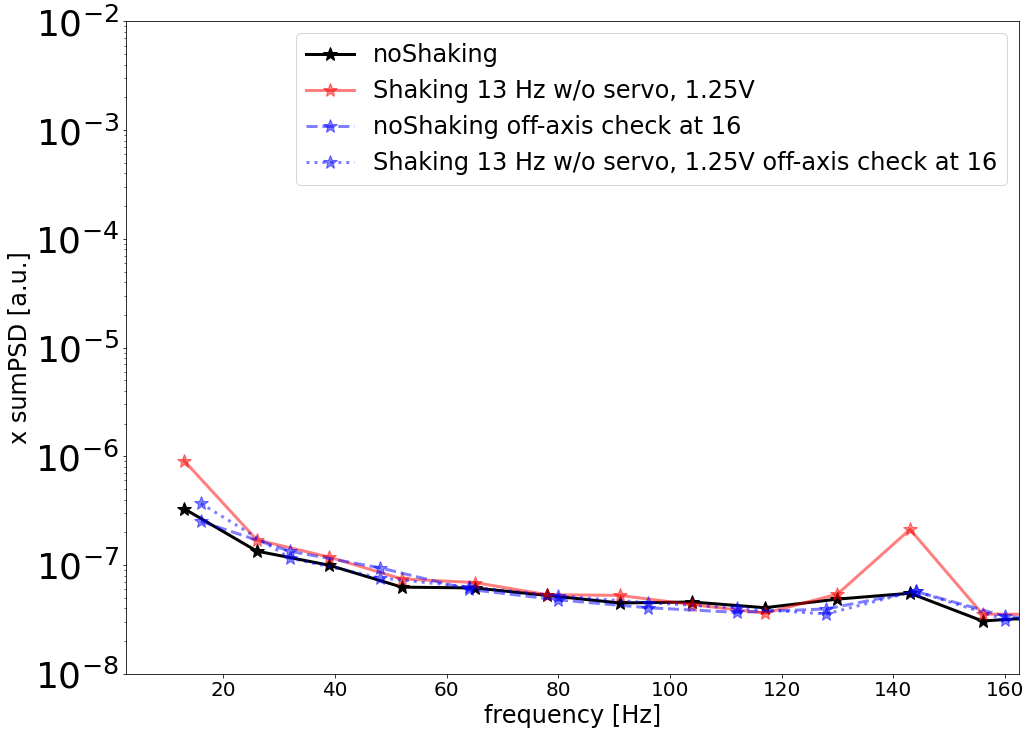

In [305]:
plotQuick(13,df_1=df_NoShaking_20220526_1,df_2=df_Shaking13Hz_20220526_retracted,label1="noShaking",label2="Shaking 13 Hz w/o servo, 1.25V",offset=3,scaleFactor=10,lowylim=1e-8,upylim=1e-2,lowxlim=1,upxlim=140)

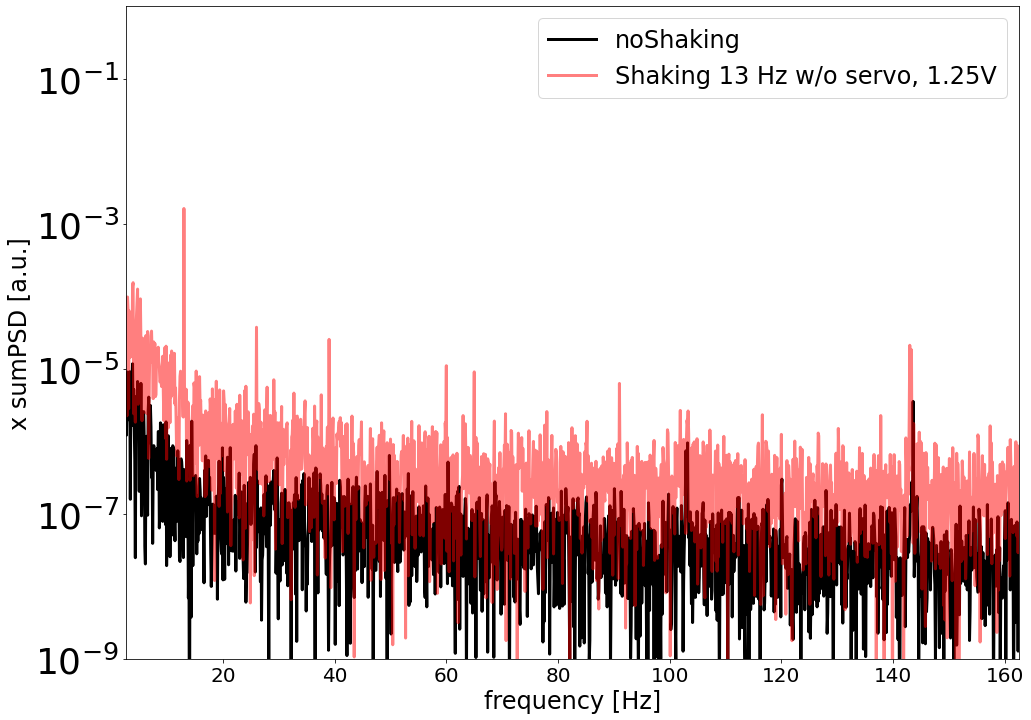

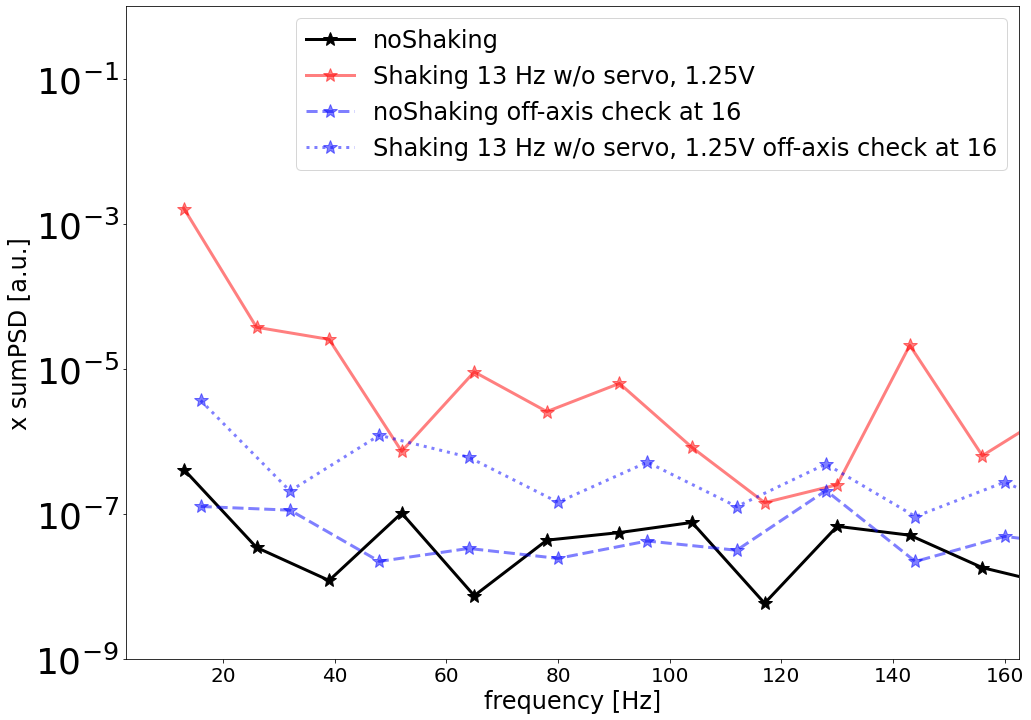

In [306]:
plotQuickAlternatemethod(13,df_1=df_NoShaking_20220526_1,df_2=df_Shaking13Hz_20220526_retracted,label1="noShaking",label2="Shaking 13 Hz w/o servo, 1.25V",offset=3,scaleFactor=100/69,lowylim=1e-9,upylim=1)
